In [1]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df =  pd.read_csv("netflix_titles.csv")


# INFORMACIÓN GENERAL DEL DATASET

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 447.3+ KB


In [3]:
df.index

RangeIndex(start=0, stop=8807, step=1)

In [4]:
df.shape

(8807, 12)

In [5]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [6]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# LIMPIEZA DATASET

## 🧹 Limpieza de datos 


   




In [7]:
# Corregimos tipo de dato(date_added) y extraemos mes y año
df['date_added']= pd.to_datetime(df['date_added'],errors='coerce')
#Comprobamos que hemos cambiado el tipo
#print(df['date_added'].dtype)

In [8]:
#Separamos la columna date_added en 2 columnas: una para el año y otra para el mes, que queremos por su nombre
df['year_added']= df['date_added'].dt.year
df['month_added']= df['date_added'].dt.month_name()
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,September
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,September
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,September
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,September
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,September


In [9]:
#convertimos la columna 'year_added' con posibles NaN a un numero entero
df['year_added'] = df['year_added'].dropna().astype('Int64')


In [10]:
#Comprobamos que ahora la columna está asociada al nuevo tipo e imprimimos el número de nulos 
print(df['year_added'].dtype)
print(df['year_added'].isnull().sum())

Int64
10


In [11]:
#Añadimos columna 'month_num' para obtener los meses por número y así poder ordenarlos y obtener métricas para gráficos, también cambiamos el tipo de datos de la columna month_num 
df['month_num'] = df['date_added'].dt.month
df['month_num'] = df['month_num'].dropna().astype('Int64')


In [12]:
#Separamos columnas complejas y las convertimos en listas
df['cast'] = df['cast'].fillna('').apply(lambda x: [i.strip() for i in x.split(',')] if x else [])
df['listed_in'] = df['listed_in'].fillna('').apply(lambda x: [i.strip() for i in x.split(',')] if x else [])
df['director'] = df['director'].fillna('').apply(lambda x: [i.strip() for i in x.split(',')] if x else [])


In [13]:
#Reemplazamos los NaN de las columnas solo tipo object(texto) y no a numéricas o fechas:
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').fillna('unknown')


In [14]:
#PROCESAMIENTO LA COLUMNA DURATION
#Comprobamos los valores que contiene la columna
df['duration'].unique()
#verificamos si hay elementos nulos
df['duration'].isna().sum()

0

In [15]:
#separamos contenido en números y unidad(min/temporadas)
#(\d+) → captura uno o más dígitos (el número)
#\s* → ignora espacios intermedios
#(\D+) → captura los caracteres no numéricos (el tipo)
df[['duration_int','duration_type']] = df['duration'].str.extract(r'(\d+)\s*(\D+)')


In [16]:
#convertimos la columna duration_int a numerico
df['duration_int'] = pd.to_numeric(df['duration_int'],errors='coerce')
#Comprobar el tipo de dato,valores únicos y los valores nulos de la columna:
#df['duration_int'].dtype
#df['duration_type'].unique()
#df['duration_type'].isna().sum()

In [17]:
#Normalizamos las unidades
df['duration_type'] = df['duration_type'].str.strip().str.lower()
df['duration_type'] = df['duration_type'].replace({
    'season':'seasons',
    'min':'minutes'
})
df['duration_int'] = df['duration_int'].dropna().astype('Int64')


In [18]:
#guardamos el nuevo dataframe modificado y comprobamos las modificaciones:
df = df.copy()
df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,month_num,duration_int,duration_type
0,s1,Movie,Dick Johnson Is Dead,[Kirsten Johnson],[],United States,2021-09-25,2020,PG-13,90 min,[Documentaries],"As her father nears the end of his life, filmm...",2021,September,9,90,minutes
1,s2,TV Show,Blood & Water,[],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"[International TV Shows, TV Dramas, TV Mysteries]","After crossing paths at a party, a Cape Town t...",2021,September,9,2,seasons
2,s3,TV Show,Ganglands,[Julien Leclercq],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",unknown,2021-09-24,2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV Ac...",To protect his family from a powerful drug lor...,2021,September,9,1,seasons
3,s4,TV Show,Jailbirds New Orleans,[],[],unknown,2021-09-24,2021,TV-MA,1 Season,"[Docuseries, Reality TV]","Feuds, flirtations and toilet talk go down amo...",2021,September,9,1,seasons
4,s5,TV Show,Kota Factory,[],"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",India,2021-09-24,2021,TV-MA,2 Seasons,"[International TV Shows, Romantic TV Shows, TV...",In a city of coaching centers known to train I...,2021,September,9,2,seasons
5,s6,TV Show,Midnight Mass,[Mike Flanagan],"[Kate Siegel, Zach Gilford, Hamish Linklater, ...",unknown,2021-09-24,2021,TV-MA,1 Season,"[TV Dramas, TV Horror, TV Mysteries]",The arrival of a charismatic young priest brin...,2021,September,9,1,seasons
6,s7,Movie,My Little Pony: A New Generation,"[Robert Cullen, José Luis Ucha]","[Vanessa Hudgens, Kimiko Glenn, James Marsden,...",unknown,2021-09-24,2021,PG,91 min,[Children & Family Movies],Equestria's divided. But a bright-eyed hero be...,2021,September,9,91,minutes
7,s8,Movie,Sankofa,[Haile Gerima],"[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra ...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"[Dramas, Independent Movies, International Mov...","On a photo shoot in Ghana, an American model s...",2021,September,9,125,minutes
8,s9,TV Show,The Great British Baking Show,[Andy Devonshire],"[Mel Giedroyc, Sue Perkins, Mary Berry, Paul H...",United Kingdom,2021-09-24,2021,TV-14,9 Seasons,"[British TV Shows, Reality TV]",A talented batch of amateur bakers face off in...,2021,September,9,9,seasons
9,s10,Movie,The Starling,[Theodore Melfi],"[Melissa McCarthy, Chris O'Dowd, Kevin Kline, ...",United States,2021-09-24,2021,PG-13,104 min,"[Comedies, Dramas]",A woman adjusting to life after a loss contend...,2021,September,9,104,minutes


## 📌Análisis descriptivo general

### 🎯 <b>Objetivo 1: ¿Qué tipo de contenido hay en Netflix (películas vs series)?</b>

📊 <b>Descripción:</b>
Queremos saber la distribución de contenido por tipo: cuántas películas y cuántas series hay.


In [19]:
#Obtenemos tipo de contenido(peli/serie)
type_counts= df['type'].value_counts()
print(type_counts)

Movie      6131
TV Show    2676
Name: type, dtype: int64


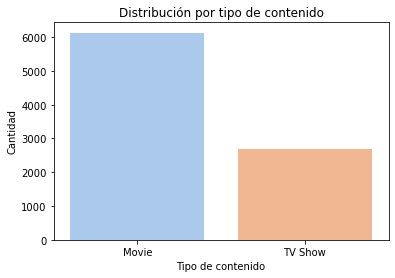

In [20]:
#Obtenemos gráfico
plt.figure(figsize=(6,4))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='pastel')
plt.title('Distribución por tipo de contenido')
plt.xlabel('Tipo de contenido')
plt.ylabel('Cantidad')
plt.show()

### 🎯 Objetivo 2: ¿Cómo ha evolucionado el contenido a lo largo de los años?

📊 <b>Descripción:</b>
Queremos ver cuántos títulos se han añadido a Netflix cada año.



In [21]:
#Nos aseguramos que 'release_year' está en formato int
df['release_year'] = df['release_year'].astype(int)


In [22]:
#Listado de las producciones por año a partir del año 2000
yearly_counts = df['release_year'].value_counts().sort_index()
print(yearly_counts.tail(22))

2000      37
2001      45
2002      51
2003      61
2004      64
2005      80
2006      96
2007      88
2008     136
2009     152
2010     194
2011     185
2012     237
2013     288
2014     352
2015     560
2016     902
2017    1032
2018    1147
2019    1030
2020     953
2021     592
Name: release_year, dtype: int64


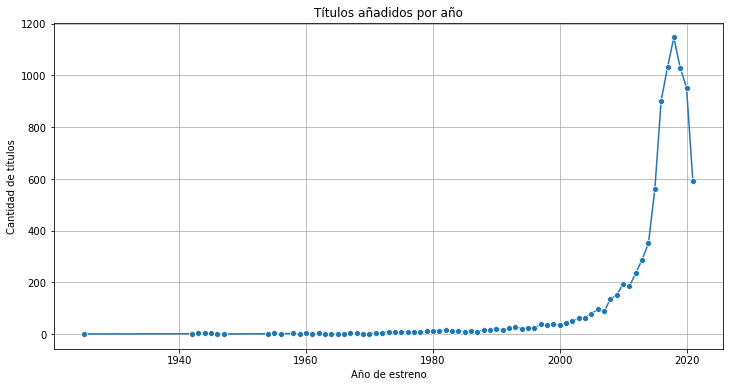

In [23]:
#Gráfico
plt.figure(figsize=(12,6))
sns.lineplot(x=yearly_counts.index,y=yearly_counts.values, marker='o')
plt.title('Títulos añadidos por año')
plt.xlabel('Año de estreno')
plt.ylabel('Cantidad de títulos')
plt.grid(True)
plt.show()

### 🎯 Objetivo 3: ¿Cuál es la duración promedio de las películas?
<b>📊 Descripción</b>
Aquí analizamos solamente películas (type == "Movie") y vemos la duración promedio, mínima y máxima.

In [24]:
#filtramos películas
movies_df = df[df['type']=='Movie']
#Estadísticas básicas:
print(movies_df['duration_int'].describe())


count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_int, dtype: float64


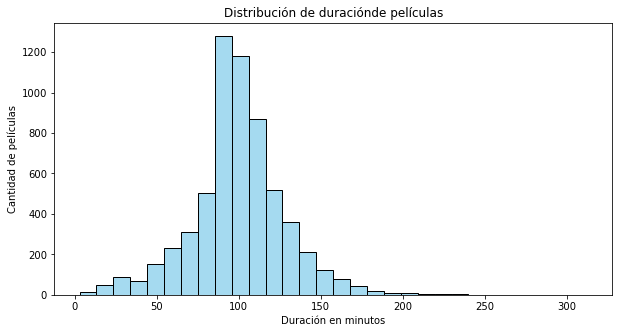

In [25]:
#Gráfico
plt.figure(figsize=(10,5))
sns.histplot(movies_df['duration_int'],bins=30,color='skyblue')
plt.title('Distribución de duraciónde películas')
plt.xlabel('Duración en minutos')
plt.ylabel('Cantidad de películas')
plt.show()

### 🎯 Objetivo 4: ¿Cuáles son los países con más contenido en Netflix?
<b>📊 Descripción</b>
Muestra los países con mayor número de títulos en la plataforma.

In [26]:
#Limpiamos el campo con los valores a una misma fila
df['country_clean'] = df['country'].fillna('unknown').apply(lambda x: x.split(',')[0].strip())


In [27]:
#Listado de los 10 paises con más producciones:
top_countries = df['country_clean'].value_counts().head(10)
print(top_countries)

United States     3211
India             1008
unknown            831
United Kingdom     628
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Name: country_clean, dtype: int64


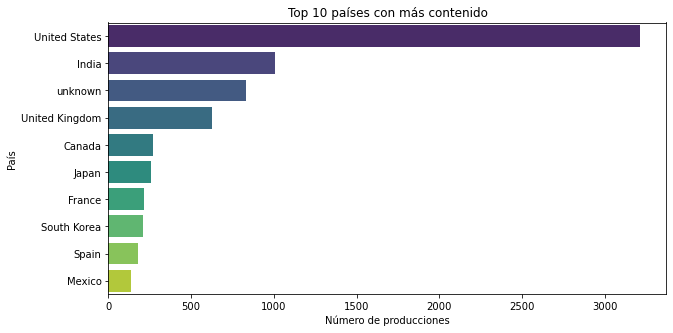

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values,y=top_countries.index, palette='viridis')
plt.title('Top 10 países con más contenido')
plt.xlabel('Número de producciones')
plt.ylabel('País')
plt.show()

### 🎯 Objetivo 5 :  ¿Cuáles son los géneros más comunes?
<b>📊 Descripción</b>
Analiza los géneros principales en Netflix.

In [29]:
#Como antes hemos convertido 'listed_in' en una lista de elementos, ahora la podemos explotar directamente:
genres_exploded = df.explode('listed_in')

#Limpiamos espacios por si acaso
genres_exploded['listed_in'] =  genres_exploded['listed_in'].str.strip()


In [30]:
#Recuento de géneros en el catálogo
top_genres = genres_exploded['listed_in'].value_counts().head(10)
print(top_genres)

International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: listed_in, dtype: int64


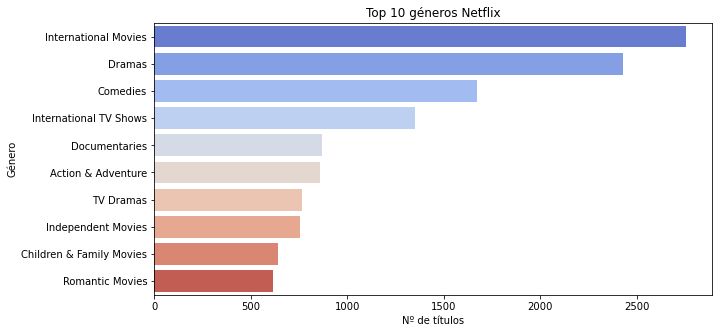

In [31]:
#Gráfico

plt.figure(figsize=(10,5))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='coolwarm')
plt.title('Top 10 géneros Netflix')
plt.xlabel('Nº de títulos')
plt.ylabel('Género')
plt.show()

### 🎯 Objetivo 6 :  ¿En que época del año se producen más lanzamientos?
<b>📊 Descripción</b>
Análisis de estacionalidad de lanzamientos en Netflix

### Listado de lanzamientos por mes

In [32]:
#Listado de lanzamientos por mes
monthly_releases = df['month_added'].value_counts().sort_values(ascending=False)
print(monthly_releases)

July         827
December     813
September    770
April        764
October      760
August       755
March        742
January      738
June         728
November     705
May          632
February     563
unknown       10
Name: month_added, dtype: int64


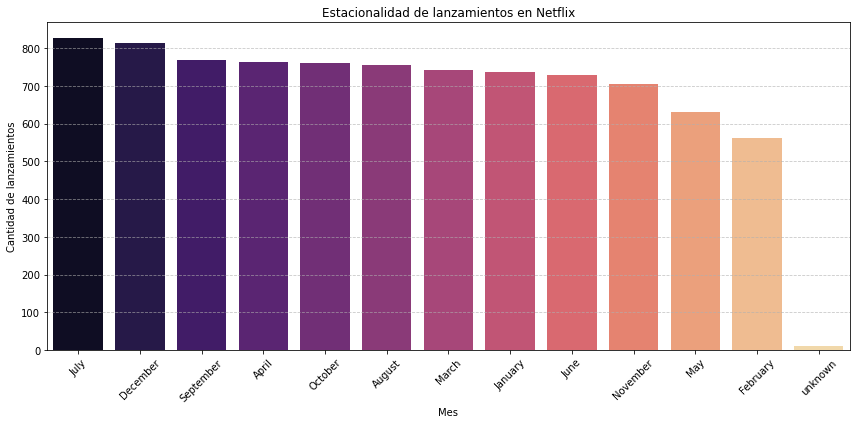

In [33]:
#Gráfico
plt.figure(figsize=(12,6))
sns.barplot(x=monthly_releases.index,y=monthly_releases.values,palette='magma')
plt.title('Estacionalidad de lanzamientos en Netflix')
plt.xlabel('Mes')
plt.ylabel('Cantidad de lanzamientos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 📑Conclusiones principales y recomendaciones

### Conclusiones principales


📍El catálogo de Netflix está compuesto mayoritariamente por películas, aunque las series muestran un crecimiento sostenido.


📍La mayor parte del contenido fue lanzado entre 2015 y 2020, con un pico evidente en años recientes, lo que indica una estrategia de expansión agresiva.
    

📍La duración promedio de las películas ronda los 90 minutos, con una distribución lógica centrada entre los 80 y 120 minutos.
   

📍Estados Unidos es con diferencia el país con mayor volumen de contenido, seguido por India, Reino Unido y Canadá.
   

📍Los géneros más comunes están relacionados con el drama, la comedia y el contenido internacional.
    

📍Existe una cierta estacionalidad en los lanzamientos, con picos en los meses de verano y navideños, probablemente alineados con las vacaciones escolares.












### Recomendaciones


📍Explorar oportunidades de crecimiento en contenido local para mercados infrarepresentados, como España o América Latina.



📍Potenciar la categoría de contenido familiar e infantil durante los meses con mayor consumo estacional.



📍Analizar posibles saturaciones en géneros dominantes y considerar diversificación en nichos emergentes.



📍Evaluar la relación entre tipo de contenido y duración para optimizar producciones futuras.



📍Investigar colaboraciones con países subrepresentados que tienen potencial de crecimiento en suscriptores.













## MÉTRICAS AVANZADAS

### 🧠 Objetivo 7 – Segmentación de contenido por clustering de géneros

<b>🎯 ¿Qué buscamos?</b>

Agrupar títulos por similaridad de géneros usando una técnica de aprendizaje no supervisado (clustering), para ver si se pueden identificar “tipos de contenido” dominantes en Netflix.

In [34]:
#convertir listas de generos a string por título
df['genre_str'] = df['listed_in'].apply(lambda x: ''.join(x))


In [35]:
#Vectorizamos:
#convertimos texto en valores numéricos
vectorizer = CountVectorizer()
X=vectorizer.fit_transform(df['genre_str'])

In [36]:
#Cluster Kmeans
#Agrupamos datos en clusters automáticos
kmeans = KMeans(n_clusters=5,random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [37]:
#Para ver los titulos de un cluster concreto, por ejemplo el 0:
df[df['cluster'] == 0][['title', 'listed_in']].head(10)
#para ver cuantos títulos hay en cada grupo
df['cluster'].value_counts()

2    3214
4    3140
1    1450
3     610
0     393
Name: cluster, dtype: int64

In [38]:
#Reducir dimensiones del cluster para visualizar datos complejos y graficar resultados
pca = PCA(n_components=2)
components = pca.fit_transform(X.toarray())

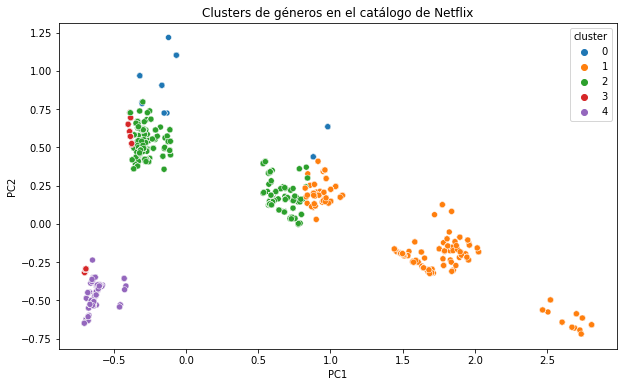

In [39]:
#Generamos nuevo dataset para poder asignar un color a cada cluster
labels = kmeans.labels_
df_pca = pd.DataFrame(
    components,
    columns=['PC1','PC2'],              # nombres para los ejes
    index=df['cluster'].index             # opcional: hereda el mismo índice
)
df_pca['cluster'] = labels             # añadimos la columna de color


plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='cluster',                       # asigna un color por etiqueta
    palette='tab10',
    legend='full'
)
plt.title('Clusters de géneros en el catálogo de Netflix')
plt.show()


In [40]:
#Identificar generos predominantes por cluster
# Explota los géneros
df['genres_list'] = df['listed_in']
genres_clustered = df.explode('genres_list')

# Agrupa por cluster y cuenta géneros más comunes
top_genres_by_cluster = genres_clustered.groupby('cluster')['genres_list'].value_counts().groupby('cluster').head(5)

print(top_genres_by_cluster)


cluster  genres_list                 
0        Stand-Up Comedy                  343
         Stand-Up Comedy & Talk Shows      50
         TV Comedies                       34
         International TV Shows            12
         Music & Musicals                   7
1        International TV Shows          1206
         TV Dramas                        629
         Crime TV Shows                   408
         Romantic TV Shows                355
         TV Comedies                      288
2        Dramas                           660
         Thrillers                        577
         Documentaries                    509
         International Movies             489
         Kids' TV                         428
3        Children & Family Movies         610
         Comedies                         270
         Dramas                            86
         Music & Musicals                  38
         International Movies              22
4        International Movies            2

## 📑Conclusiones específicas:

📍<b>Comedia en vivo muy diferenciada</b>: el análisis crea un clúster exclusivo de Stand-Up y Talk Shows, indicando un nicho sólido para monólogos y especiales de comedia.


📍<b>Series internacionales de drama y crimen</b>: otro grupo agrupa mayoritariamente International TV Shows, Dramas y Crime TV Shows, señalando fuerte demanda de producciones foráneas y de investigación.


📍<b>Películas diversificadas</b>: el bloque principal fusiona cine serio (drama, thriller, documental), cine familiar/comedia ligera y películas internacionales/independientes.

## 📊 Objetivo 8 – Simulación de recomendador simple basado en similitud de contenido
<b>🎯 ¿Qué buscamos?</b>
Dado un título concreto, recomendar otros similares según el contenido textual (descripción, género, tipo…).

In [41]:
#Hay que unir description,listed_in y type en un solo campo:
df['combined'] = df['type'] + ' ' + df['description'].fillna('') + ' ' + df['genre_str']


In [42]:
#Vectorizamos con TdifVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined'])

In [43]:
#vamos a usar NearestNeighbor,que permite encontrar, para un punto dado, 
#los puntos más cercanos (similares) en un conjunto de datos.
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [49]:
# Buscar similares a un título específico
idx=35 #suponemos que quermos la similitud del titulo en la fila i, en este caso 35
distances, indices = model.kneighbors(tfidf_matrix[idx], n_neighbors=6)

In [50]:
# Mostrar resultados excluyendo el mismo título
df.iloc[indices[0][1:]][['title', 'description']]

,title,description
8686,Waar,When Pakistani authorities learn of a looming ...
2272,Drishyam,An unexceptional man becomes a murder suspect ...
7803,Punjab 1984,"During a time of political turmoil, a mother g..."
8683,Vodka Diaries,While investigating a series of murders and th...
8652,Ugly,When a 10-year-old goes missing while her fath...


In [51]:
#Mapeo entre títulos y su índice
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

#Función basada en NearestNeighbors
def recomendar(titulo, top_n=5):
    idx = indices[titulo]
    distances, neighbors = model.kneighbors(tfidf_matrix[idx], n_neighbors=top_n+1)  # +1 porque el más cercano es el mismo
    similares = neighbors[0][1:]  # Excluye el propio título
    return df.iloc[similares][['title', 'type', 'listed_in', 'description']]


In [52]:
recomendar('Breaking Bad', top_n=5)


,title,type,listed_in,description
2606,Extracurricular,TV Show,"[Crime TV Shows, International TV Shows, Korea...",A model high school student who's steeped in a...
4118,Iron Ladies,TV Show,"[International TV Shows, Romantic TV Shows, TV...",Three 30-something women in high-level jobs at...
1587,Detention,TV Show,"[International TV Shows, TV Dramas, TV Horror]",A tormented student uncovers unsettling secret...
6616,Dismissed,Movie,[Thrillers],An intelligent but intense honor student traum...
5352,"Have You Ever Fallen in Love, Miss Jiang?",TV Show,"[Crime TV Shows, International TV Shows, TV Dr...",A new teacher finds herself in an unenviable s...
